In [1]:
import re
import numpy as np
import multiprocessing as mp
import sys
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date, time

from scipy.stats import pearsonr
import seaborn as sns

def merge_pkl_files(folder_path):
    """
    合并指定文件夹下所有 .pkl 文件到一个 DataFrame
    
    参数:
        folder_path (str): 包含 .pkl 文件的文件夹路径（例如 "文件夹/IC/"）
    
    返回:
        pd.DataFrame: 合并后的数据
    """
    from tqdm import tqdm
    import os
    # 获取所有 .pkl 文件列表
    pkl_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]
    
    # 检查是否找到文件
    if not pkl_files:
        raise ValueError(f"未找到 .pkl 文件于: {folder_path}")
    
    # 逐个读取并合并
    dfs = []
    for file in tqdm(pkl_files, desc="合并文件中"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_pickle(file_path)  # 读取单个文件
        dfs.append(df)
    
    # 合并所有 DataFrame
    merged_df = pd.concat(dfs, axis=0, ignore_index=True)
    return merged_df

folder_path = "股指期货市场数据（近三年）/IC/"

# 合并数据
try:
    combined_data = merge_pkl_files(folder_path)

    # 可选：保存合并后的数据到新文件
    int_time = combined_data.index.astype(int)
    combined_data['datetime'] = pd.to_datetime(combined_data['time'], unit='ms') + pd.Timedelta(hours=8)
    df = combined_data.reset_index()
    df = df.set_index('datetime') 
    print(df)
    print(type(df.index[0]))
    df = df.sort_index()
except Exception as e:
    print(f"错误: {e}")

In [2]:
df_IF = pd.read_pickle('IF.pkl')
df_IH = pd.read_pickle('IH.pkl')
df_IC = pd.read_pickle('IC.pkl')
df_IM = pd.read_pickle('IM.pkl')

In [3]:
df_IC

,basis,contract_close,index_close,basis_chg,index_close_chg
2022-06-15 09:30:00,6.429,6281.8,6275.371,NaN,NaN
2022-06-15 09:31:00,3.945,6304.4,6300.455,-2.484,25.084
2022-06-15 09:32:00,1.761,6316.0,6314.239,-2.184,13.784
2022-06-15 09:33:00,9.259,6318.2,6308.941,7.498,-5.298
2022-06-15 09:34:00,8.002,6329.4,6321.398,-1.257,12.457
...,...,...,...,...,...
2025-05-16 14:56:00,-107.734,5610.2,5717.934,0.717,0.083
2025-05-16 14:57:00,-110.628,5607.0,5717.628,-2.894,-0.306
2025-05-16 14:58:00,-113.117,5605.0,5718.117,-2.489,0.489
2025-05-16 14:59:00,-115.717,5602.4,5718.117,-2.600,0.000


In [4]:
# class order_manager:
#     def __init__(self):
#         self.open_orders = {}
#         self.closed_orders = []
#         self.order_id = 1
#         self.money = 1000000
#         self.fee_rate_t1 = 0.000023 #万分之0.23
#         self.fee_rate_t0 = 0.00023
#         self.equity = self.money
#         self.contract_size = 300

#     def open_order(self, code, position, price, open_time, lot, slip=0.0001): 

#         order_id = f"{self.order_id:06d}"
#         self.order_id += 1
        
#         if position == 1:
#             price = price + price * slip
            
#         if position == -1:
#             price = price - price * slip
        
#         value = price*self.contract_size*lot
#         open_fee = value*self.fee_rate_t1
        
#         order_info = {
#             'order_id':order_id,
#             'code':code,
#             'open_price':price,
#             'open_time':open_time,
#             'position':position,
#             'lot':lot, 
#             'value':value, 
#             'open_fee':open_fee,
#             #'balance':balance,
#             #'equity':equity
#         } 

#         self.open_orders[order_id] = order_info
#         #print(f"开仓成功 - ID: {order_id} | 方向: {position} | 品种: {code} | 价格: {price} | 手数: {lot}")
#         return order_id
    
#     def close_order(self, order_id, price, close_time, slip=0.0001):
        
#         if order_id not in self.open_orders:
#             print(f"平仓失败 - 未找到订单ID: {order_id}")
#             return None
    
#         order = self.open_orders.pop(order_id) #取出并删除指定键对应的值！

#         #平仓滑点计算
#         if order['position'] == 1: #平多仓
#             price = price - price * slip
#             profit = (price - order['open_price'])*order['lot']*self.contract_size
#         elif order['position'] == -1: #平空仓
#             price = price + price * slip
#             profit = -(price - order['open_price'])*order['lot']*self.contract_size
        
#         #手续费计算
#         if (close_time.date()-order['open_time'].date()).days == 0:
#             close_fee = price * order['lot'] * self.contract_size * self.fee_rate_t0
#         elif (close_time.date()-order['open_time'].date()).days > 0:
#             close_fee = price * order['lot'] * self.contract_size * self.fee_rate_t1
        
#         net_profit = profit  - order['open_fee'] - close_fee
#         self.equity = self.equity + net_profit
        
#         closed_order = {
#             **order,
#             'close_price': price,
#             'close_time': close_time,
#             'profit': profit,
#             'fee': order['open_fee'] + close_fee,
#             'net_profit': net_profit,
#             'equity' : self.equity,
#             'position' : order['position'],
#             'holding_period': (close_time - order['open_time']).total_seconds() / 3600
#         }
        
#         self.closed_orders.append(closed_order)
        
#         #print(f"平仓成功 - ID: {order_id} | 方向: {order['position']} | "
#              # f":手数: {order['lot']} | 开仓价: {order['open_price']} | "
#               #f"平仓价: {price} | 净利润: {net_profit:.2f}")
        
#         return closed_order
    

    
class OrderManager:
    def __init__(self, initial_capital=1_000_000, contract_size=300):
        self.open_orders = {}          # {order_id: order_info}
        self.closed_orders = []        # [closed_order_info]
        self.order_id_counter = 1      # +++ 更明确的命名
        self.equity = initial_capital  # +++ 仅保留权益，移除冗余balance
        self.contract_size = contract_size
        self.fee_rates = {
            'intraday': 0.00023,   # T+0费率
            'overnight': 0.000023  # T+1费率
        }
    
    # +++ 新增方法：计算手续费
    def _calculate_fee(self, price, lot, is_intraday):
        rate = self.fee_rates['intraday'] if is_intraday else self.fee_rates['overnight']
        return price * lot * self.contract_size * rate

    # +++ 新增方法：计算滑点后的价格
    def _apply_slippage(self, price, position, slippage):
        return price * (1 + slippage) if position == 1 else price * (1 - slippage)

    def open_order(self, code, position, price, open_time, lot, slippage=0.0001):
        order_id = f"{self.order_id_counter:06d}"
        self.order_id_counter += 1
        
        # 应用滑点
        executed_price = self._apply_slippage(price, position, slippage)  # +++ 封装逻辑
        
        # 计算手续费（默认按隔夜费率，平仓时根据实际调整）
        fee = self._calculate_fee(executed_price, lot, is_intraday=False)  # +++
        
        order_info = {
            'order_id': order_id,
            'code': code,
            'position': position,
            'open_price': executed_price,
            'open_time': open_time,
            'lot': lot,
        }
        
        self.open_orders[order_id] = order_info
        return order_id

    def close_order(self, order_id, price, close_time, slippage=0.0001):
        if order_id not in self.open_orders:
            raise KeyError(f"Order {order_id} not found")  # +++ 改为异常抛出
        
        order = self.open_orders.pop(order_id)
        
        # 计算平仓价和盈亏
        executed_price = self._apply_slippage(price, -order['position'], slippage)  # +++ 方向取反
        profit = (executed_price - order['open_price']) * order['lot'] * self.contract_size * order['position']
        
        # 判断是否日内交易
        is_intraday = (close_time.date() == order['open_time'].date())  # +++
        close_fee = self._calculate_fee(executed_price, order['lot'], is_intraday)  # +++
        
        # 更新权益
        net_profit = profit - order['open_fee'] - close_fee
        self.equity += net_profit
        
        closed_order = {
            **order,
            'close_price': executed_price,
            'close_time': close_time,
            'gross_profit': profit,
            'net_profit': net_profit,
            'holding_period': (close_time - order['open_time']).total_seconds() / 3600,
        }
        
        self.closed_orders.append(closed_order)
        return closed_order

    # +++ 新增方法：批量获取持仓
    def get_position(self):
        if self.open_orders:
            current_position = pd.DataFrame(self.open_orders.values())['position'].sum()
        else:
            current_position = 0
            
        return current_position

In [5]:
manager = order_manager()

NameError: name 'order_manager' is not defined

In [ ]:
def fixed_time_close(code, start_time, end_time, raw_data,window = 30):
    start_time = datetime.strptime(start_time, '%Y%m%d')
    end_time = datetime.strptime(end_time, '%Y%m%d')
    
    data = raw_data.loc[start_time:end_time].copy()
    
    data['basis_chg_MA'] = data['basis_chg'].rolling(window=window).mean()
    data['basis_chg_std'] =  data['basis_chg'].rolling(window=window).std()
    data['Upper'] = data['basis_chg_MA'] + 2 * data['basis_chg_std']
    data['Lower'] = data['basis_chg_MA'] - 2 * data['basis_chg_std']
    
    time_list = list(data.index)
    for time in time_list:
#注意list(manager.open_orders.items())返回的是许多元组构成的列表，每个元组为（id,字典）
        for order_id, order_info in list(manager.open_orders.items()):
            if time >= order_info['open_time'] + timedelta(minutes=15):
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time]['contract_close'],  # 使用当前价格平仓
                    close_time=time,
                    slip = 0
                )
                
        basis = data.loc[time]['basis']
        basis_chg = data.loc[time]['basis_chg']
        upper = data.loc[time]['Upper']
        lower = data.loc[time]['Lower']
        
        if basis_chg < lower:
            long_order = manager.open_order(
                code = code,
                position = -1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )
            
        if basis_chg > upper:
            short_order = manager.open_order(
                code = code,
                position = 1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )

In [ ]:
def classic_bollinger_chg(code, start_time, end_time, raw_data, window=30, k=2):
    start_time = datetime.strptime(start_time, '%Y%m%d')
    end_time = datetime.strptime(end_time, '%Y%m%d')
    
    data = raw_data.loc[start_time:end_time].copy()
    
    data['basis_chg_MA'] = data['basis_chg'].rolling(window=window).mean()
    data['basis_chg_std'] =  data['basis_chg'].rolling(window=window).std()
    data['Upper'] = data['basis_chg_MA'] + k * data['basis_chg_std']
    data['Lower'] = data['basis_chg_MA'] - k * data['basis_chg_std']
    
    time_list = list(data.index)
    for time in time_list:
#注意list(manager.open_orders.items())返回的是许多元组构成的列表，每个元组为（id,字典）
                
        basis = data.loc[time]['basis']
        basis_chg = data.loc[time]['basis_chg']
        upper = data.loc[time]['Upper']
        lower = data.loc[time]['Lower']
        basis_chg_MA = data.loc[time]['basis_chg_MA']
        
        for order_id, order_info in list(manager.open_orders.items()):
            # 多头平仓条件：当前basis_chg从上方回归中轨
            if order_info['position'] == 1 and basis_chg <= basis_chg_MA:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time]['contract_close'],
                    close_time=time
                )
            # 空头平仓条件：当前basis_chg从下方回归中轨
            elif order_info['position'] == -1 and basis_chg >= basis_chg_MA:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time]['contract_close'],
                    close_time=time
                )
        
        
        if basis_chg < lower:
            long_order = manager.open_order(
                code = code,
                position = -1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )
            
        if basis_chg > upper:
            short_order = manager.open_order(
                code = code,
                position = 1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )

In [ ]:
def classic_bollinger(code, start_time, end_time, raw_data, window=30, k=2):
    start_time = datetime.strptime(start_time, '%Y%m%d')
    end_time = datetime.strptime(end_time, '%Y%m%d')
    
    data = raw_data.loc[start_time:end_time].copy()
    
    data['basis_MA'] = data['basis'].rolling(window=window).mean()
    data['basis_std'] =  data['basis'].rolling(window=window).std()
    data['Upper'] = data['basis_MA'] + k * data['basis_std']
    data['Lower'] = data['basis_MA'] - k * data['basis_std']
    
    time_list = list(data.index)
    for time in time_list:
#注意list(manager.open_orders.items())返回的是许多元组构成的列表，每个元组为（id,字典）
                
        basis = data.loc[time]['basis']
        #basis_chg = data.loc[time]['basis_chg']
        upper = data.loc[time]['Upper']
        lower = data.loc[time]['Lower']
        basis_MA = data.loc[time]['basis_MA']
        
        for order_id, order_info in list(manager.open_orders.items()):
            # 多头平仓条件：当前basis_chg从上方回归中轨
            if order_info['position'] == 1 and basis <= basis_MA:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time]['contract_close'],
                    close_time=time
                )
            # 空头平仓条件：当前basis_chg从下方回归中轨
            elif order_info['position'] == -1 and basis >= basis_MA:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time]['contract_close'],
                    close_time=time
                )
        
        
        if basis < lower:
            long_order = manager.open_order(
                code = code,
                position = -1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )
            
        if basis > upper:
            short_order = manager.open_order(
                code = code,
                position = 1,
                price = data.loc[time]['contract_close'],
                open_time = time,
                lot = 1
            )
            
    return data

In [7]:
def plt_output_basis(average_basis_by_time, index = 'time', max_time_ticks=20):
        plt.rcParams["font.family"] = ["sans-serif"]
        average_basis_by_time.index = average_basis_by_time[index].astype(str)

        plt.figure(figsize=(14, 7))

        if isinstance(average_basis_by_time, pd.DataFrame) and 'avg_basis' in average_basis_by_time.columns:
            plt.plot(average_basis_by_time[index], average_basis_by_time['avg_basis'], label='avg_basis', linewidth=1, color='blue')
        else:
            print(" error: 'avg_basis' ")

        plt.title(f'avg_basis')
        plt.xlabel('time')
        plt.ylabel('avg_basis')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best') 
        ax = plt.gca()
        # date_format = mdates.DateFormatter('%Y-%m-%d')
        # ax.xaxis.set_major_formatter(date_format)

        if max_time_ticks > 0:
            ax.xaxis.set_major_locator(plt.MaxNLocator(max_time_ticks))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

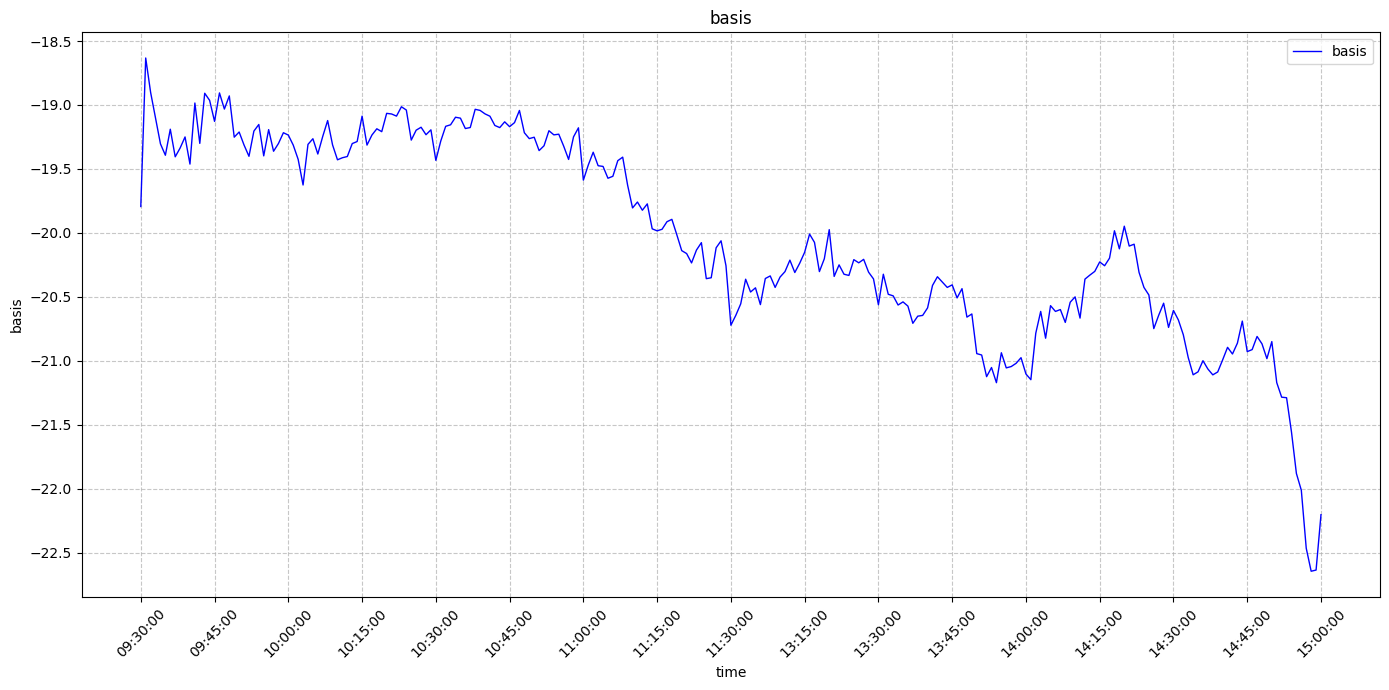

In [6]:
def y_slice_analyse(df, y, opentime, closetime, slice_standard = 'time'):
    def plt_output_y(average_y_by_time, index = 'time', max_time_ticks=20):
        plt.rcParams["font.family"] = ["sans-serif"]
        average_y_by_time.index = average_y_by_time[index].astype(str)

        plt.figure(figsize=(14, 7))

        if isinstance(average_y_by_time, pd.DataFrame) and y in average_y_by_time.columns:
            plt.plot(average_y_by_time[index], average_y_by_time[y], label=y, linewidth=1, color='blue')
        else:
            print(f" error: '{y}' ")
            return

        plt.title(y)
        plt.xlabel('time')
        plt.ylabel(y)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best') 
        ax = plt.gca()

        if max_time_ticks > 0:
            ax.xaxis.set_major_locator(plt.MaxNLocator(max_time_ticks))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    df = df.copy()
    # 时间切片
    df = df[opentime:closetime]

    # 创建时间切片列
    if slice_standard == 'time':
        df[f'{slice_standard}'] = df.index.time
        df[f'{slice_standard}'] = (df[f'{slice_standard}'].astype(str))
    else:
        df[f'{slice_standard}'] = df.index.date
        df[f'{slice_standard}'] = (df[f'{slice_standard}'].astype(str))
        if slice_standard == 'day':
            df[f'{slice_standard}'] = df[f'{slice_standard}'].str[-5:]
        elif slice_standard == 'month':
            df[f'{slice_standard}'] = df[f'{slice_standard}'].str[-5:-3]
        elif slice_standard == 'year':
            df[f'{slice_standard}'] = df[f'{slice_standard}'].str[0:4]
        else:
            print("wrong input type")
            return

    average_y_by_standard = df.groupby(f'{slice_standard}')[y].mean().reset_index()
    average_y_by_standard.columns = [f'{slice_standard}', y]

    average_y_by_standard = average_y_by_standard.sort_values(f'{slice_standard}')
    plt_output_y(average_y_by_standard, index = f'{slice_standard}')
    return

y_slice_analyse(df_IF, 'basis', '2025', '2025')

# IC 500
# IF 300
# IH 50
# IM 1000


In [ ]:
def strategy_1(code, start_time, end_time, raw_data, k1, k2):
    #k1:开仓信号，k2:平仓信号
    #manager = order_manager()
    start_time = datetime.strptime(start_time, '%Y%m%d')
    end_time = datetime.strptime(end_time, '%Y%m%d')
    
    data = raw_data.loc[start_time:end_time].copy()
    basis_org = data['basis'].iloc[0]
    
    time_list = list(data.index)
    for time_now in time_list:
        basis = data.loc[time_now]['basis']
        b_signal = basis - basis_org

        #注意list(manager.open_orders.items())返回的是许多元组构成的列表，每个元组为（id,字典）
        for order_id, order_info in list(manager.open_orders.items()):

            if order_info['position'] == 1 and b_signal <= k2:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time_now]['contract_close'],
                    close_time=time_now
                )

            elif order_info['position'] == -1 and b_signal >= -k2:
                manager.close_order(
                    order_id=order_id,
                    price=data.loc[time_now]['contract_close'],
                    close_time=time_now
                )
                
        current_position = manager.get_positions()
                
        if b_signal > k1 and current_position == 0:
            long_order = manager.open_order(
                code = code,
                position = 1,
                price = data.loc[time_now]['contract_close'],
                open_time = time_now,
                lot = 1
            )
    
        if b_signal < -k1 and current_position == 0:
            short_order = manager.open_order(
                code = code,
                position = -1,
                price = data.loc[time_now]['contract_close'],
                open_time = time_now,
                lot = 1
            )
            
        if time_now.time() == time(15, 0):
            basis_org = data.loc[time_now]['basis']
            
            if manager.closed_orders:
                equity = manager.closed_orders[-1]['equity']
            else:
                equity = manager.money
            
            daily_info = {
                'time': time_now,
                'equity': equity
            }
            
            manager.daily_infos.append(daily_info)
            
    return data

In [ ]:
def execute_trade(
    manager: OrderManager,
    code: str,
    current_time: datetime,
    price: float,
    signal: int,
    close_conditions: dict = None,
    lot: int = 1
) -> None:
    """
    独立交易执行函数
    
    参数:
        manager: 订单管理器实例
        code: 标的代码
        current_time: 当前时间
        price: 当前价格
        signal: 交易信号 (1=多, -1=空, 0=无)
        close_conditions: 平仓条件字典，例如:
            {
                'position': 1,  # 仓位方向
                'condition': lambda x: x <= 0  # 平仓条件函数
            }
        lot: 交易手数
    """
    # --- 平仓逻辑 ---
    if close_conditions:
        for order_id, order_info in list(manager.open_orders.items()):
            # 检查是否满足平仓条件
            if (order_info['position'] == close_conditions['position'] and 
                close_conditions['condition'](signal)):
                manager.close_order(
                    order_id=order_id,
                    price=price,
                    close_time=current_time
                )
    
    # --- 开仓逻辑 ---
    if signal == 1:  # 多头开仓
        manager.open_order(
            code=code,
            position=1,
            price=price,
            open_time=current_time,
            lot=lot
        )
    elif signal == -1:  # 空头开仓
        manager.open_order(
            code=code,
            position=-1,
            price=price,
            open_time=current_time,
            lot=lot
        )

In [10]:
df = pd.read_pickle('IF copy.pkl')

In [11]:
df

,time,open,high,low,contract_close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,index_close,basis
2022-05-23 09:30:00,20220523,4063.0,4063.0,4063.0,4063.0,171,2.084319e+08,0.0,139055,4063.0,0,4080.969,-17.969
2022-05-23 09:31:00,20220523,4062.8,4062.8,4049.4,4052.2,2066,2.513941e+09,0.0,137810,4063.0,0,4073.800,-21.600
2022-05-23 09:32:00,20220523,4052.0,4052.0,4042.6,4044.4,1644,1.995953e+09,0.0,136915,4052.2,0,4066.909,-22.509
2022-05-23 09:33:00,20220523,4044.6,4048.0,4040.4,4048.0,1443,1.750318e+09,0.0,136046,4044.4,0,4067.160,-19.160
2022-05-23 09:34:00,20220523,4048.0,4048.0,4036.2,4041.0,1361,1.650133e+09,0.0,135368,4048.0,0,4063.317,-22.317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-16 14:56:00,20250516,3849.6,3851.0,3849.4,3849.6,460,5.313115e+08,0.0,154048,3849.8,0,3890.223,-40.623
2025-05-16 14:57:00,20250516,3849.6,3850.4,3848.2,3848.6,468,5.404358e+08,0.0,154202,3849.6,0,3888.737,-40.137
2025-05-16 14:58:00,20250516,3848.6,3848.6,3847.8,3848.2,540,6.234155e+08,0.0,154449,3848.6,0,3888.787,-40.587
2025-05-16 14:59:00,20250516,3848.2,3849.0,3847.2,3847.2,613,7.076912e+08,0.0,154616,3848.2,0,3888.787,-41.587


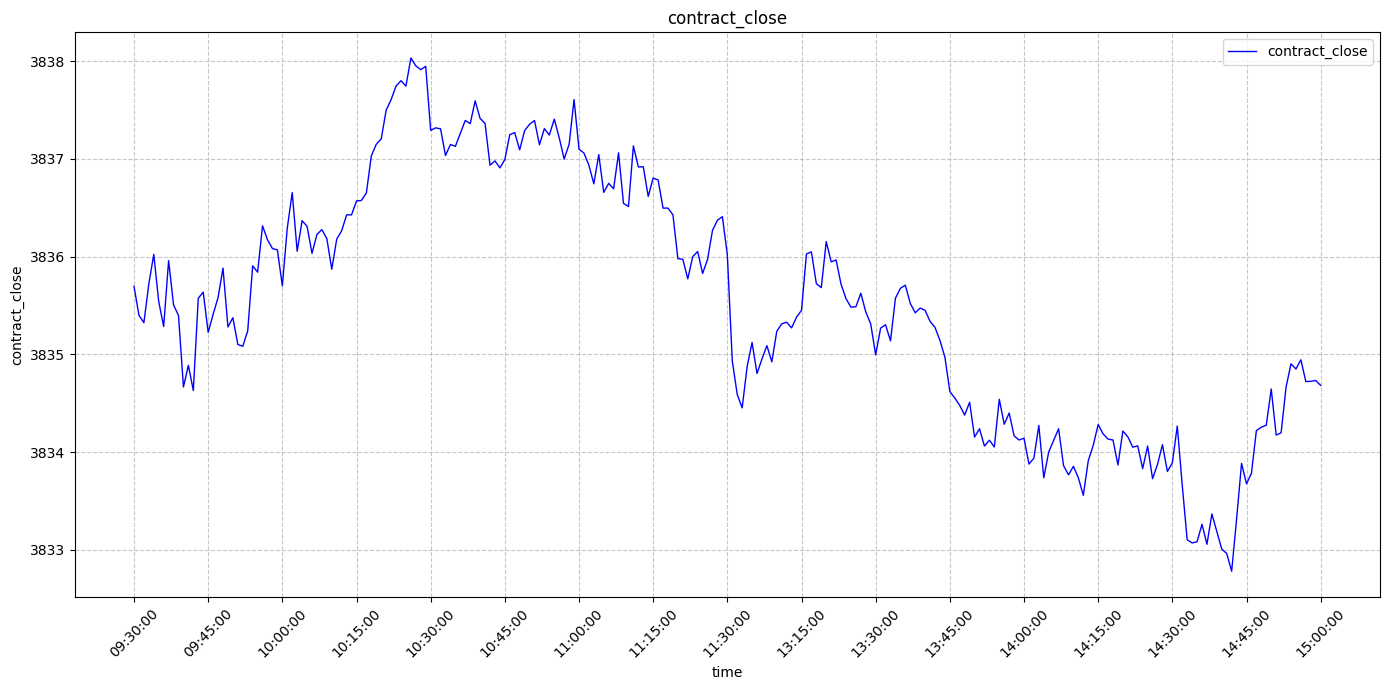

In [19]:
y_slice_analyse(df, 'contract_close', '2025', '2025', 'time')

In [ ]:
#fixed_time_close('IF','20250101','20250520',df_IF,30)
#classic_bollinger_chg('IF', '20250101', '20250520', df_IF, window=30, k=2)
#data = classic_bollinger('IF', '20250103', '20250107', df_IF, window=240, k=3)
data, manager = strategy_1('IF', '20240101', '20241231', df_IF, k1=10, k2=10)
manager.open_orders

AttributeError: 'order_manager' object has no attribute 'get_positions'

In [ ]:
closed_orders_df = pd.DataFrame(manager.closed_orders)
closed_orders_df

,order_id,code,open_price,open_time,position,lot,value,open_fee,close_price,close_time,profit,fee,net_profit,equity,holding_period
0,000001,IF,3391.46082,2024-01-02 14:47:00,-1,1,1017438.246,23.401080,3391.13908,2024-01-02 14:49:00,96.522,257.389676,-160.867676,9.998391e+05,0.033333
1,000002,IF,3390.86088,2024-01-02 14:48:00,-1,1,1017258.264,23.396940,3391.13908,2024-01-02 14:49:00,-83.460,257.385537,-340.845537,9.994983e+05,0.016667
2,000003,IF,3390.26094,2024-01-02 14:52:00,-1,1,1017078.282,23.392800,3385.33850,2024-01-03 09:30:00,1476.732,46.751636,1429.980364,1.000928e+06,18.633333
3,000004,IF,3390.66090,2024-01-02 14:53:00,-1,1,1017198.270,23.395560,3385.33850,2024-01-03 09:30:00,1596.720,46.754396,1549.965604,1.002478e+06,18.616667
4,000005,IF,3390.86088,2024-01-02 14:54:00,-1,1,1017258.264,23.396940,3385.33850,2024-01-03 09:30:00,1656.714,46.755776,1609.958224,1.004088e+06,18.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5172,005173,IF,3991.19908,2024-12-26 10:07:00,1,1,1197359.724,27.539274,3988.40112,2024-12-26 10:08:00,-839.388,302.738951,-1142.126951,9.853107e+05,0.016667
5173,005174,IF,4020.20198,2024-12-27 11:15:00,1,1,1206060.594,27.739394,4013.39862,2024-12-27 11:18:00,-2041.008,304.663898,-2345.671898,9.829651e+05,0.050000
5174,005175,IF,4020.60202,2024-12-27 11:16:00,1,1,1206180.606,27.742154,4013.39862,2024-12-27 11:18:00,-2161.020,304.666659,-2465.686659,9.804994e+05,0.033333
5175,005176,IF,4017.80174,2024-12-27 11:17:00,1,1,1205340.522,27.722832,4013.39862,2024-12-27 11:18:00,-1320.936,304.647337,-1625.583337,9.788738e+05,0.016667


In [ ]:
closed_orders_df.to_csv('order_book.csv', index=False)

In [ ]:
manager.open_orders

{}

In [ ]:
trading_calendar = pd.read_pickle('trading_calendar.pkl')
trading_calendar = trading_calendar.values.flatten().tolist()

def get_trading_days(start_date, close_date):
    trade_cal = []
    # 格式判断和转换
    if isinstance(start_date, pd.Timestamp):
        start_date = start_date.strftime('%Y%m%d')
    if isinstance(close_date, pd.Timestamp):
        close_date = close_date.strftime('%Y%m%d')
    
    if start_date in trading_calendar:
        if close_date in trading_calendar:
            trade_cal = trading_calendar[trading_calendar.index(start_date):trading_calendar.index(close_date) + 1]
    return trade_cal

def get_detail_analyze(df, risk_free_rate=0.016):
        """生成详细的交易分析结果"""
        results = {}
        
        start_date = pd.to_datetime(df['open_time'].iloc[0].date())
        end_date = pd.to_datetime(df['close_time'].iloc[-1].date())
        
        start_idx = trading_calendar.index(start_date.strftime('%Y%m%d'))
        end_idx = trading_calendar.index(end_date.strftime('%Y%m%d'))
        
        trading_days = end_idx - start_idx + 1

        daily_returns = df.groupby(pd.to_datetime(df['close_time'].dt.date))['net_profit'].sum() / \
                        df.groupby(pd.to_datetime(df['close_time'].dt.date))['equity'].first() - \
                        df.groupby(pd.to_datetime(df['close_time'].dt.date))['net_profit'].first()
        annualized_return = daily_returns.sum()/trading_days * 252
        annualized_volatility = daily_returns.std() * np.sqrt(252)
        results['夏普比率'] = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

        total_profit = df[df['net_profit'] > 0]['net_profit'].sum()
        total_loss = abs(df[df['net_profit'] < 0]['net_profit'].sum())
        results['盈亏比'] = total_profit / total_loss if total_loss != 0 else float('inf')
        
        total_return = (df['equity'].iloc[-1] / manager.money - 1) 
        results['总收益率(%)'] = total_return * 100

        results['年化收益率(%)'] = total_return * 252/trading_days * 100

        wins = (df['net_profit'] > 0).sum()
        results['胜率'] = wins / len(df) if len(df) > 0 else 0
        
        ### 持有时间计算
        holding_times = []
        cal = get_trading_days(df['open_time'].min(), df['close_time'].max())
        
        morning_start = time(9, 30)
        morning_end = time(11, 30)
        afternoon_start = time(13, 0)
        afternoon_end = time(15, 0)
        
        for index, row in df.iterrows():
            open_time = row['open_time']  # datetime 对象
            close_time = row['close_time']  # datetime 对象

            open_date = open_time.date()
            close_date = close_time.date()

            open_date_str = open_date.strftime('%Y%m%d')
            close_date_str = close_date.strftime('%Y%m%d')

            try:
                day_during = cal.index(close_date_str) - cal.index(open_date_str)
            except ValueError:
                print(f"日期不在交易日历中: {open_date_str} 或 {close_date_str}")
                continue

            # 计算持有时间
            holding_time = timedelta()

            # 处理同一天内的交易
            if day_during == 0:
                if close_time.time() <= morning_end:
                    holding_time = close_time - open_time
                elif open_time.time() >= afternoon_start:
                    holding_time = close_time - open_time
                else:
                    morning_part = datetime.combine(open_time.date(), morning_end) - open_time
                    afternoon_part = close_time - datetime.combine(close_time.date(), afternoon_start)
                    holding_time = morning_part + afternoon_part

            # 处理跨天交易
            else:
                first_day_part = datetime.combine(open_time.date(), afternoon_end) - open_time
                last_day_part = close_time - datetime.combine(close_time.date(), morning_start)

                if open_time.time() >= afternoon_start:
                    first_day_part = datetime.combine(open_time.date(), afternoon_end) - open_time
                elif open_time.time() <= morning_end:
                    first_day_part = (datetime.combine(open_time.date(), morning_end) - open_time) + timedelta(hours=1, minutes=30)

                if close_time.time() <= morning_end:
                    last_day_part = close_time - datetime.combine(close_time.date(), morning_start)
                elif close_time.time() >= afternoon_start:
                    last_day_part = close_time - datetime.combine(close_time.date(), afternoon_start)

                full_days = day_during - 1
                middle_days_part = timedelta(hours=4, minutes=30) * full_days

                holding_time = first_day_part + middle_days_part + last_day_part

            # 转换为小时
            holding_hours = round(holding_time.total_seconds() / 3600, 2)
            holding_times.append(holding_hours)

        results['平均持有时间（H）'] = sum(holding_times)/len(holding_times)
    
        df = df.copy()
        peaks = df['equity'].cummax()
        drawdowns = (peaks - df['equity']) / peaks
        results['相对最大回撤(%)'] = drawdowns.max() * 100
        
        results = pd.DataFrame([results]).round(2)

        return results

In [ ]:
def plt_output(equity, max_time_ticks=20):
        plt.rcParams["font.family"] = ["sans-serif"]
        equity.index = equity['open_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        equity = equity.drop('order_id', axis = 1)

        plt.figure(figsize=(14, 7))

        if isinstance(equity, pd.DataFrame) and 'equity' in equity.columns:
            plt.plot(equity.index, equity['equity'], label='equity', linewidth=2, color='blue')
        else:
            print(" error: 'equity' ")

        plt.title(f'equity')
        plt.xlabel('time')
        plt.ylabel('equity')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='best') 
        ax = plt.gca()
        # date_format = mdates.DateFormatter('%Y-%m-%d')
        # ax.xaxis.set_major_formatter(date_format)

        if max_time_ticks > 0:
            ax.xaxis.set_major_locator(plt.MaxNLocator(max_time_ticks))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

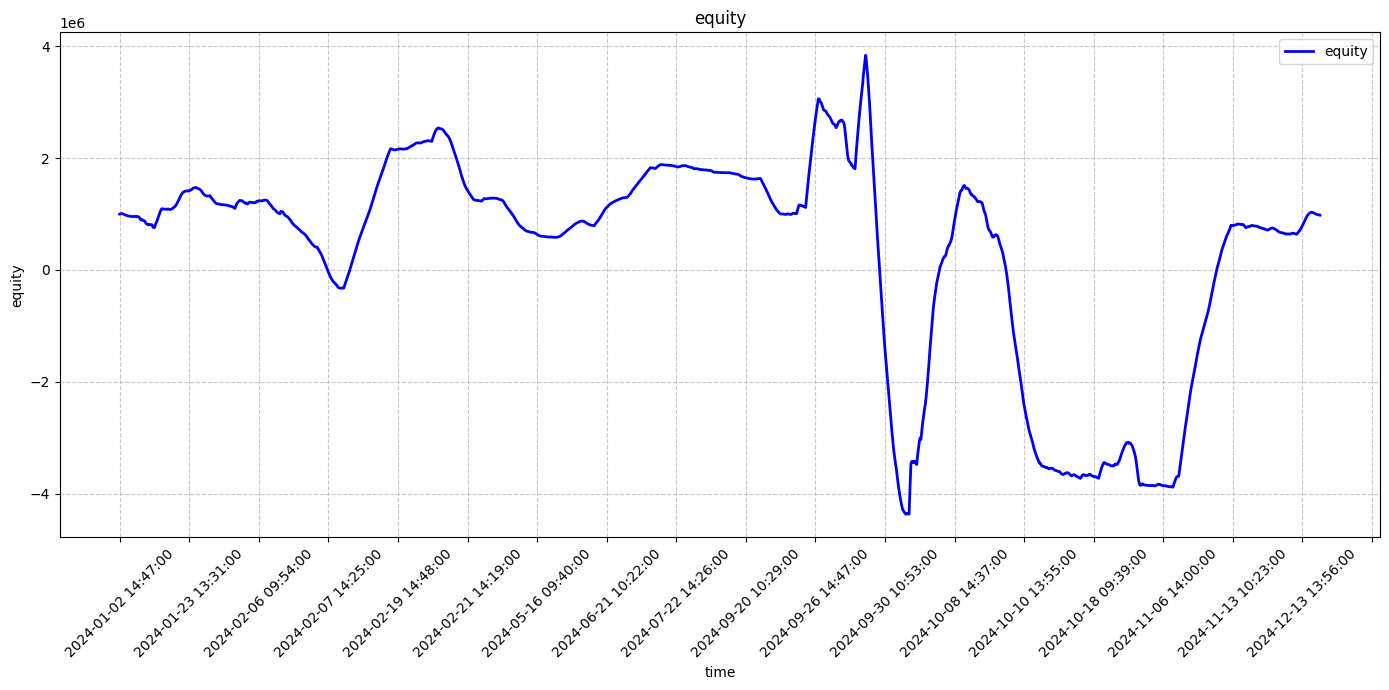

In [ ]:
plt_output(closed_orders_df)

In [ ]:
get_detail_analyze(closed_orders_df)

,夏普比率,盈亏比,总收益率(%),年化收益率(%),胜率,平均持有时间（H）,相对最大回撤(%)
0,-1.57,1.0,-2.1,-2.2,0.44,0.86,213.8


def plt_output_bollinger(df,start_date = '2025-01-02 09:30:00', close_date = '2025-05-16 15:00:00'):

    # Ensure index is datetime type
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    # Copy data and reset index to use string labels
    df = df.copy()

    df = df.loc[start_date:close_date]

    df_plot = df.reset_index()
    
    df_plot['x_label'] = df_plot['index'].dt.strftime('%Y%-%m%d %H:%M')
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot basis change and indicators using string x-axis
    x_positions = range(len(df_plot))  # Use integer positions
    
    #ax.scatter(x_positions, df_plot['basis_chg'], label='Basis Change', color='blue', s=10, alpha=0.8)
    ax.plot(x_positions, df_plot['basis'], label='basis', color='blue', linewidth=1.0)
    ax.plot(x_positions, df_plot['basis_MA'], label='basis_MA', color='red', linewidth=1.5)
    ax.plot(x_positions, df_plot['Upper'], label='Upper', color='green', linestyle='--', linewidth=1.0)
    ax.plot(x_positions, df_plot['Lower'], label='Lower', color='green', linestyle='--', linewidth=1.0)
    
    # Set plot title and labels
    ax.set_title('Basis Analysis', fontsize=16)
    ax.set_ylabel('Basis Value', fontsize=12)
    ax.set_xlabel('Trading Time', fontsize=12)
    
    # Add grid and legend
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='best', fontsize=10)
    
    # Set x-axis labels with controlled density
    max_ticks = 20  # Maximum number of x-axis labels to display
    if len(df_plot) > max_ticks:
        step = len(df_plot) // max_ticks
        ax.set_xticks(x_positions[::step])
        ax.set_xticklabels(df_plot['x_label'][::step], rotation=45)
    else:
        ax.set_xticks(x_positions)
        ax.set_xticklabels(df_plot['x_label'], rotation=45)
    
    plt.tight_layout()
    return fig, ax

plt_output_bollinger(data,start_date = '2025-05-15 09:30:00', close_date = '2025-05-15 15:00:00')